In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import lusee_sky

In [12]:
wf=np.load('waterfalls/wfall_4.0_56.0_0.25_3.0_3.0.npz',allow_pickle=True)['wfall']
## for this, let's merge them. In other words, 11 nights worht of observations in one go
wf=np.vstack(wf)
freq = np.arange(4,56,0.25)
assert(len(freq)==wf.shape[1])

maxfreq=15
freq = np.arange(4,maxfreq,0.25)
wf = wf[:,:len(freq)]
wf.shape
gsignal = lusee_sky.get_signal(freq)

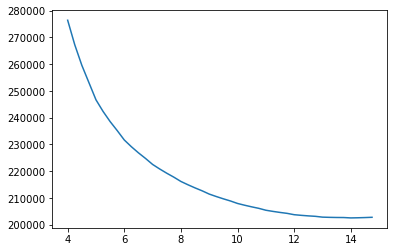

In [13]:
we = (freq/freq[len(freq)//2])**2.70
wfw = wf*we[None,:]
plt.plot(freq,wfw.mean(axis=0))


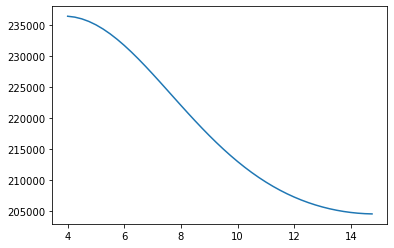

In [14]:
wfw = scipy.ndimage.gaussian_filter(wfw,[0,12])
plt.plot(freq,wfw.mean(axis=0))

In [15]:
cov_from_mean_subtracted = True
print(wfw.shape)
if cov_from_mean_subtracted:
    wfw_nomean =  wfw-wfw.mean(axis=0)
    cov = np.cov(wfw_nomean,rowvar=False)
else:
    cov = np.array([np.outer(t,t) for t in wfw]).mean(axis=0)

(16960, 44)


In [16]:
eva,evec = np.linalg.eigh(cov)
endx = np.argsort(eva)[::-1]

[]

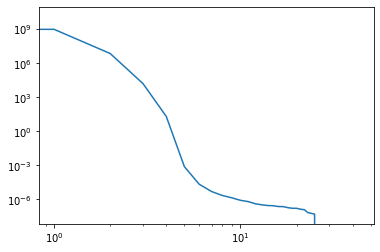

In [17]:
plt.plot(eva[endx])
plt.loglog()

(-0.25, 0.25)

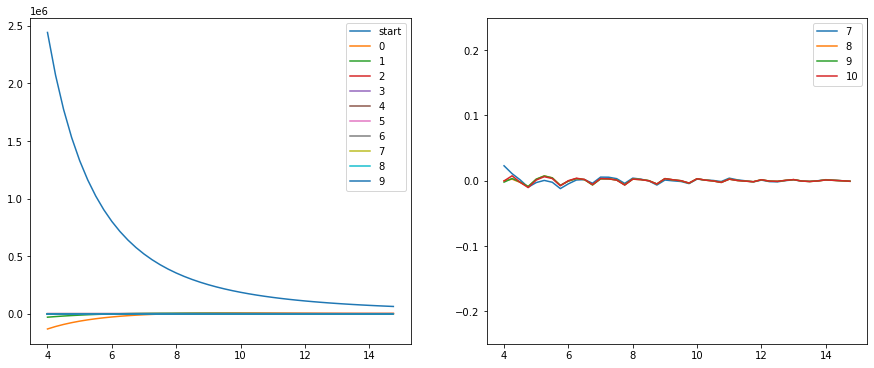

In [18]:
tosub = wfw.copy()
Nmax=10
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(freq,tosub.mean(axis=0)/we,label='start')
for ii,ndx in enumerate(endx[:Nmax]):
    vec = evec[:,ndx]
    norm = np.dot(vec,vec)
    wex = (tosub*vec[None,:]).sum(axis=1)/norm
    tosub -= np.outer(wex,vec)
    weare = tosub.mean(axis=0)
    ax1.plot(freq, weare/we,label=str(ii))
    if ii>Nmax-5:
        ax2.plot(freq, weare/we,label=str(ii+1))

ax1.legend()
ax2.legend()
ax2.set_ylim(-0.25,0.25)

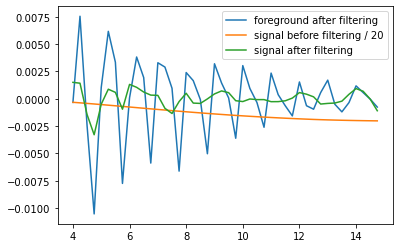

In [19]:
gsigwe = gsignal*we
plt.plot(freq,weare/we,label='foreground after filtering')
plt.plot(freq,gsigwe/we/20, label='signal before filtering / 20')
for ii,ndx in enumerate(endx[:Nmax]):
    vec = evec[:,ndx]
    norm = np.dot(vec,vec)
    wex = np.dot(gsigwe,vec)/norm
    gsigwe -= wex*vec
    
plt.plot(freq,gsigwe/we, label='signal after filtering')
plt.legend()
#plt.ylim(-0.01,0.01)